In [1]:
import pandas as pd
import numpy as np
from collections import Iterable
from nltk.tag import ClassifierBasedTagger
from nltk.chunk import ChunkParserI, conlltags2tree
from nltk.stem.snowball import SnowballStemmer
from nltk import pos_tag, word_tokenize
from spacy import displacy
import keras.backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras_contrib import losses, metrics
from keras import backend
import matplotlib.pyplot as plt
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from keras.initializers import RandomUniform
from newspaper import Article
import re



class EntityChunker(ChunkParserI):
    def __init__(self, train_sents, **kwargs):
        assert isinstance(train_sents, Iterable)

        self.feature_detector = features
        self.tagger = ClassifierBasedTagger(
            train=train_sents,
            feature_detector=features,
            **kwargs)

    def parse(self, tagged_sent):
        chunks = self.tagger.tag(tagged_sent)
        iob_triplets = [(w, t, c) for ((w, t), c) in chunks]
        
        return iob_triplets


def features(tokens, index, history):
    """
    'tokens'  = a POS-tagged sentence [(w1, t1), ...]
    'index'   = the index of the token we want to extract features for
    'history' = the previous predicted IOB tags
    """

    # init the stemmer
    stemmer = SnowballStemmer('english')

    # Pad the sequence with placeholders
    tokens = [('[START2]', '[START2]'), ('[START1]', '[START1]')] + list(tokens) + [('[END1]', '[END1]'),
                                                                                    ('[END2]', '[END2]')]
    history = ['[START2]', '[START1]'] + list(history)

    # shift the index with 2, to accommodate the padding
    index += 2

    word, pos = tokens[index]
    prevword, prevpos = tokens[index - 1]
    prevprevword, prevprevpos = tokens[index - 2]
    nextword, nextpos = tokens[index + 1]
    nextnextword, nextnextpos = tokens[index + 2]
    previob = history[index - 1]
    contains_dash = '-' in word
    contains_dot = '.' in word
    allascii = all([True for c in word if c in string.ascii_lowercase])

    allcaps = word == word.capitalize()
    capitalized = word[0] in string.ascii_uppercase

    prevallcaps = prevword == prevword.capitalize()
    prevcapitalized = prevword[0] in string.ascii_uppercase

    nextallcaps = prevword == prevword.capitalize()
    nextcapitalized = prevword[0] in string.ascii_uppercase

    return {
        'word': word,
        'lemma': stemmer.stem(word),
        'pos': pos,
        'all-ascii': allascii,

        'next-word': nextword,
        'next-lemma': stemmer.stem(nextword),
        'next-pos': nextpos,

        'next-next-word': nextnextword,
        'nextnextpos': nextnextpos,

        'prev-word': prevword,
        'prev-lemma': stemmer.stem(prevword),
        'prev-pos': prevpos,

        'prev-prev-word': prevprevword,
        'prev-prev-pos': prevprevpos,

        'prev-iob': previob,

        'contains-dash': contains_dash,
        'contains-dot': contains_dot,

        'all-caps': allcaps,
        'capitalized': capitalized,

        'prev-all-caps': prevallcaps,
        'prev-capitalized': prevcapitalized,

        'next-all-caps': nextallcaps,
        'next-capitalized': nextcapitalized,
    }

Using TensorFlow backend.


In [2]:
data_file_path = '/Users/TonY/Desktop/sfl/Dataset_01-29-2019.txt'
data = pd.read_csv(data_file_path, delimiter='\t',
                   header=0, index_col=0,
                   names=['Sentence', 'Word', 'POS', 'Tag'],
                   encoding='unicode_escape')

# Check datatype
data.dtypes
# Change float to int
data.Sentence = data.Sentence.astype(int)
# Check NA
data.isna().any()

Sentence    False
Word        False
POS         False
Tag         False
dtype: bool

In [3]:
# Total number of Sentences
max(data.Sentence)

# Tag Count by category
# ART, EVE, NAT has too few data points
data.Tag.value_counts()

O        56217
B-geo     2070
B-org     1237
I-per     1234
B-gpe     1230
B-tim     1160
B-per     1107
I-org      926
I-geo      414
I-tim      334
B-art       53
B-eve       45
I-eve       37
I-gpe       34
I-art       34
B-nat       20
I-nat        9
Name: Tag, dtype: int64

In [4]:
sentence_arr = data.Sentence.unique()
token = []
for sentence in sentence_arr:
    temp_data = data[data['Sentence'] == sentence]
    curr_index = temp_data.index
    one_sentence = []
    for index in curr_index:
        one_sentence.append((temp_data.Word[index], temp_data.POS[index], temp_data.Tag[index]))
    token.append(one_sentence)
    
sentences = token


In [5]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words)
print(n_words)
tags = list(set(data["Tag"].values))
n_tags = len(tags)
print(n_tags)
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
# print(word2idx)
tag2idx = {t: i for i, t in enumerate(tags)}
print(tag2idx)

8767
17
{'B-gpe': 0, 'B-nat': 1, 'B-eve': 2, 'O': 3, 'I-org': 4, 'I-gpe': 5, 'I-eve': 6, 'B-org': 7, 'I-art': 8, 'I-per': 9, 'B-per': 10, 'B-tim': 11, 'B-art': 12, 'I-nat': 13, 'B-geo': 14, 'I-geo': 15, 'I-tim': 16}


In [6]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

In [7]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
# print(y)
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [8]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [9]:
# input = Input(shape=(max_len,))
# model = Embedding(input_dim=n_words + 1, output_dim=20,
#                   input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
# model = Bidirectional(LSTM(units=50, return_sequences=True,
#                            recurrent_dropout=0.1))(model)  # variational biLSTM
# model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
# crf = CRF(n_tags)  # CRF layer
# out = crf(model)  # output

In [10]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=80,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=200, return_sequences=True,
                           recurrent_dropout=0.5))(model)  # variational biLSTM
model = TimeDistributed(Dense(200, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

In [11]:
model = Model(input, out)
# model.compile(optimizer="rmsprop", loss=losses.crf_loss, metrics=[metrics.crf_accuracy])
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

/Users/TonY/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras_contrib-2.0.8-py3.6.egg/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
/Users/TonY/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras_contrib-2.0.8-py3.6.egg/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 80)            701440    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 400)           449600    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 200)           80200     
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 17)            3740      
Total params: 1,234,980
Trainable params: 1,234,980
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=6, validation_split=0.1, verbose=1)

Train on 2429 samples, validate on 270 samples
Epoch 1/6
2429/2429 [==============================] - 23s 10ms/step - loss: 0.3034 - crf_viterbi_accuracy: 0.9306 - val_loss: 0.1692 - val_crf_viterbi_accuracy: 0.9579
Epoch 2/6
2429/2429 [==============================] - 23s 9ms/step - loss: 0.1329 - crf_viterbi_accuracy: 0.9637 - val_loss: 0.1071 - val_crf_viterbi_accuracy: 0.9704
Epoch 3/6
2429/2429 [==============================] - 27s 11ms/step - loss: 0.0907 - crf_viterbi_accuracy: 0.9726 - val_loss: 0.0908 - val_crf_viterbi_accuracy: 0.9739
Epoch 4/6
2429/2429 [==============================] - 30s 12ms/step - loss: 0.0713 - crf_viterbi_accuracy: 0.9786 - val_loss: 0.0785 - val_crf_viterbi_accuracy: 0.9779
Epoch 5/6
2429/2429 [==============================] - 30s 12ms/step - loss: 0.0564 - crf_viterbi_accuracy: 0.9834 - val_loss: 0.0721 - val_crf_viterbi_accuracy: 0.9808
Epoch 6/6
2429/2429 [==============================] - 31s 13ms/step - loss: 0.0460 - crf_viterbi_accuracy: 0

In [13]:
hist = pd.DataFrame(history.history)
hist

,val_loss,val_crf_viterbi_accuracy,loss,crf_viterbi_accuracy
0,0.169236,0.957926,0.303391,0.930589
1,0.107139,0.970370,0.132860,0.963672
2,0.090782,0.973877,0.090748,0.972631
3,0.078541,0.977926,0.071252,0.978565
4,0.072058,0.980790,0.056444,0.983362
5,0.066942,0.981827,0.045997,0.986496


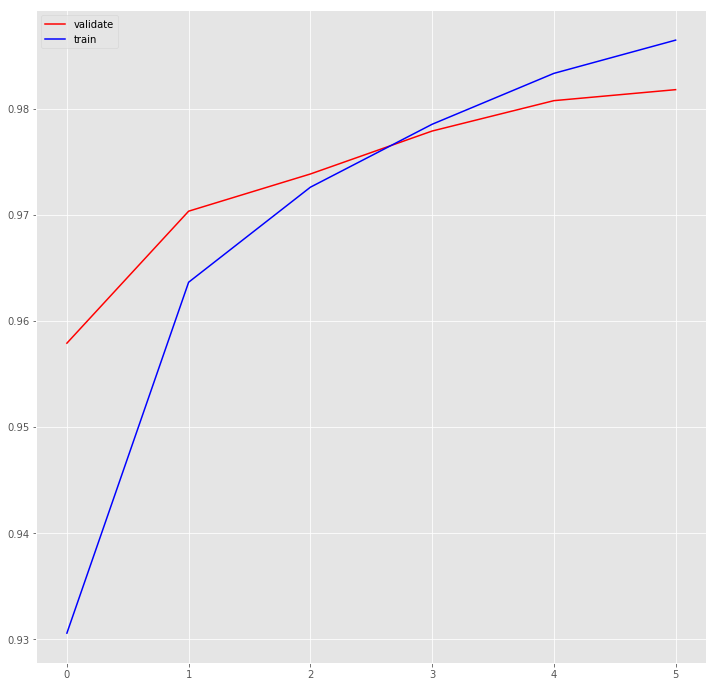

In [14]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
# plt.plot(hist["val_crf_accuracy"])
# plt.plot(hist["crf_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"], color='red', label = 'validate')
plt.plot(hist["crf_viterbi_accuracy"], color = 'blue', label = 'train')
plt.legend(loc='upper left')
plt.show()


In [15]:
test_pred = model.predict(X_te, verbose=1)

300/300 [==============================] - 2s 5ms/step


In [16]:
idx2tag = {i: w for w, i in tag2idx.items()}
print(idx2tag)
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

{0: 'B-gpe', 1: 'B-nat', 2: 'B-eve', 3: 'O', 4: 'I-org', 5: 'I-gpe', 6: 'I-eve', 7: 'B-org', 8: 'I-art', 9: 'I-per', 10: 'B-per', 11: 'B-tim', 12: 'B-art', 13: 'I-nat', 14: 'B-geo', 15: 'I-geo', 16: 'I-tim'}


In [17]:
print("Accuracy: {:.1%}".format(f1_score(test_labels, pred_labels)))

Accuracy: 62.0%


In [18]:
def url2text(url):
    """
    This function takes in an url of the news article and output as string of text.
    Returns a string with formated data, pads before and after each special symbol
    """
    toi_article = Article(url, language="en") # en for English
    toi_article.download() 
  
    #To parse the article 
    toi_article.parse()
    
    #To extract text 
    test_sentence = toi_article.text
    # Padding one space before and after the special symbol, not pad if already padded
#     test_sentence = re.sub('(?<! )(?=[.,!?%#^&*@$:;()"\'`-])|(?<=[.,!?%#^&*@$:;()"\'`-])(?! )', r' ', test_sentence)
    
    return test_sentence


def render_nltk_ner(test_sentence):
    """
    This function serves to take the text output of the function "url2text", 
    restructure the data and then renders using SpaCy API. 
    It shows both iob token and the rendered text"
    """
    for line in test_sentence.splitlines():    
        test_sentence = line.split()
        # print(test_sentence)
        x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                                padding="post", value=0, maxlen=max_len)

        p = model.predict(np.array([x_test_sent[0]]))
        p = np.argmax(p, axis=-1)
        iob_out = []

        for w, pred in zip(test_sentence, p[0]):
            iob_out.append((w, 'NA', tags[pred]))

        ent_hash = {}
        ent_list = []
        hash_list = []
        sentence = []

        start_index = 0
        for i, iob in enumerate(iob_out):
            sentence.append(iob[0])
            sentence_full = ' '.join(map(str, sentence))
            if iob[2].startswith('B-'):
                temp = [iob_out[i][0]]
                try:
                    iob_out[i+1][2]
                    if iob_out[i+1][2] == 'O':
                        word = ' '.join(map(str, temp))
                        ent_hash = {'word': word,
                                    "start": len(sentence_full) - len(word),
                                    "end": len(sentence_full),
                                    "label": iob_out[i][2][2:].upper()}

                        hash_list.append(ent_hash)
                except IndexError:
                     break
                        
            elif iob[2].startswith('I-'):
                temp.append(iob_out[i][0])
                try:
                    iob_out[i+1][2]
                    if iob_out[i+1][2] == 'O':
                        word = ' '.join(map(str, temp))
                        ent_hash = {'word': word,
                                    "start": len(sentence_full) - len(word),
                                    "end": len(sentence_full),
                                    "label": iob_out[i][2][2:].upper()}
                        hash_list.append(ent_hash)
                except IndexError:
                     break
                    

        ent = {'text': line,
               'ents': hash_list,
               'title': None}

        displacy.render(ent, manual=True, style="ent", jupyter=True)
        
    return 


def render_nltk_ner_with_iob(test_sentence):
    """
    This function serves to take the text output of the function "url2text", 
    restructure the data and then renders using SpaCy API. 
    It shows both iob token and the rendered text"
    """
    for line in test_sentence.splitlines():    
        test_sentence = line.split()
        # print(test_sentence)
        x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                                padding="post", value=0, maxlen=max_len)

        p = model.predict(np.array([x_test_sent[0]]))
        p = np.argmax(p, axis=-1)
        iob_out = []

        for w, pred in zip(test_sentence, p[0]):
            iob_out.append((w, 'NA', tags[pred]))
        # Print iob token
        print(iob_out)

        ent_hash = {}
        ent_list = []
        hash_list = []
        sentence = []

        start_index = 0
        for i, iob in enumerate(iob_out):
            sentence.append(iob[0])
            sentence_full = ' '.join(map(str, sentence))
            if iob[2].startswith('B-'):
                temp = [iob_out[i][0]]
                try:
                    iob_out[i+1][2]
                    if iob_out[i+1][2] == 'O':
                        word = ' '.join(map(str, temp))
                        ent_hash = {'word': word,
                                    "start": len(sentence_full) - len(word),
                                    "end": len(sentence_full),
                                    "label": iob_out[i][2][2:].upper()}

                        hash_list.append(ent_hash)
                except IndexError:
                     break
                        
            elif iob[2].startswith('I-'):
                temp.append(iob_out[i][0])
                try:
                    iob_out[i+1][2]
                    if iob_out[i+1][2] == 'O':
                        word = ' '.join(map(str, temp))
                        ent_hash = {'word': word,
                                    "start": len(sentence_full) - len(word),
                                    "end": len(sentence_full),
                                    "label": iob_out[i][2][2:].upper()}
                        hash_list.append(ent_hash)
                except IndexError:
                     break
                    

        ent = {'text': line,
               'ents': hash_list,
               'title': None}

        displacy.render(ent, manual=True, style="ent", jupyter=True)
        
    return 

In [19]:
url = "https://www.cnn.com/2019/04/13/politics/tax-reform-winners-and-losers/index.html"
text = url2text(url) 
render_nltk_ner(text)

In [20]:
render_nltk_ner_with_iob(text)

[('(CNN)', 'NA', 'B-gpe'), ('Tax', 'NA', 'O'), ('day', 'NA', 'O'), ("isn't", 'NA', 'B-gpe'), ('until', 'NA', 'O'), ('Monday,', 'NA', 'B-gpe'), ('but', 'NA', 'O'), ('there', 'NA', 'O'), ('have', 'NA', 'O'), ('already', 'NA', 'O'), ('been', 'NA', 'O'), ('some', 'NA', 'O'), ('surprises', 'NA', 'B-gpe'), ('for', 'NA', 'O'), ('Americans', 'NA', 'B-gpe'), ('filing', 'NA', 'B-gpe'), ('their', 'NA', 'O'), ('first', 'NA', 'O'), ('income', 'NA', 'O'), ('tax', 'NA', 'O'), ('returns', 'NA', 'O'), ('under', 'NA', 'O'), ('President', 'NA', 'B-per'), ('Donald', 'NA', 'I-per'), ("Trump's", 'NA', 'B-gpe'), ('2017', 'NA', 'I-per'), ('law.', 'NA', 'B-gpe')]


[]


[("Let's", 'NA', 'B-gpe'), ('start', 'NA', 'O'), ('with', 'NA', 'O'), ('the', 'NA', 'O'), ('big', 'NA', 'O'), ('one.', 'NA', 'B-gpe'), ('While', 'NA', 'O'), ('most', 'NA', 'O'), ('Americans', 'NA', 'B-gpe'), ('are', 'NA', 'O'), ('paying', 'NA', 'O'), ('less', 'NA', 'O'), ('in', 'NA', 'O'), ('taxes', 'NA', 'O'), ('overall,', 'NA', 'B-gpe'), ('many', 'NA', 'O'), ('have', 'NA', 'O'), ('been', 'NA', 'O'), ('startled', 'NA', 'B-gpe'), ('to', 'NA', 'O'), ('find', 'NA', 'O'), ('that', 'NA', 'O'), ('their', 'NA', 'O'), ('refunds', 'NA', 'B-gpe'), ('have', 'NA', 'O'), ('barely', 'NA', 'O'), ('changed', 'NA', 'O'), ('or', 'NA', 'O'), ('are', 'NA', 'O'), ('down', 'NA', 'O'), ('--', 'NA', 'O'), ('making', 'NA', 'O'), ('them', 'NA', 'O'), ('feel', 'NA', 'O'), ('like', 'NA', 'O'), ('they', 'NA', 'O'), ('lost,', 'NA', 'B-gpe'), ('even', 'NA', 'O'), ('if', 'NA', 'O'), ("they're", 'NA', 'B-gpe'), ('still', 'NA', 'O'), ('coming', 'NA', 'O'), ('out', 'NA', 'O'), ('ahead.', 'NA', 'B-gpe')]


[]


[('Below', 'NA', 'B-gpe'), ('are', 'NA', 'O'), ('some', 'NA', 'O'), ('other', 'NA', 'O'), ('ways', 'NA', 'O'), ('to', 'NA', 'O'), ('look', 'NA', 'O'), ('at', 'NA', 'O'), ('who', 'NA', 'O'), ('is', 'NA', 'O'), ('winning', 'NA', 'O'), ('and', 'NA', 'O'), ('losing', 'NA', 'B-gpe'), ('under', 'NA', 'O'), ('the', 'NA', 'O'), ('law.', 'NA', 'B-gpe'), ('And', 'NA', 'O'), ('please', 'NA', 'B-gpe'), ('take', 'NA', 'O'), ('note:', 'NA', 'B-gpe'), ("It's", 'NA', 'B-gpe'), ('possible', 'NA', 'O'), ('to', 'NA', 'O'), ('both', 'NA', 'O'), ('win', 'NA', 'O'), ('and', 'NA', 'O'), ('lose', 'NA', 'O'), ('at', 'NA', 'O'), ('the', 'NA', 'O'), ('same', 'NA', 'O'), ('time.', 'NA', 'B-gpe')]


[]


[('Winning:', 'NA', 'B-gpe'), ('Most', 'NA', 'O'), ('US', 'NA', 'B-tim'), ('taxpayers', 'NA', 'B-gpe')]


[]


[('The', 'NA', 'O'), ('vast', 'NA', 'O'), ('majority', 'NA', 'O'), ('of', 'NA', 'O'), ('American', 'NA', 'B-gpe'), ('tax', 'NA', 'O'), ('filers', 'NA', 'B-gpe'), ('--', 'NA', 'O'), ('more', 'NA', 'O'), ('than', 'NA', 'O'), ('65%', 'NA', 'B-gpe'), ('--', 'NA', 'O'), ('will', 'NA', 'O'), ('see', 'NA', 'O'), ('their', 'NA', 'O'), ('overall', 'NA', 'O'), ('tax', 'NA', 'O'), ('burden', 'NA', 'O'), ('decrease', 'NA', 'O'), ('by', 'NA', 'O'), ('at', 'NA', 'O'), ('least', 'NA', 'O'), ('$100,', 'NA', 'B-gpe'), ('according', 'NA', 'O'), ('to', 'NA', 'O'), ('the', 'NA', 'O'), ('congressional', 'NA', 'O'), ('Joint', 'NA', 'B-org'), ('Committee', 'NA', 'I-org'), ('on', 'NA', 'O'), ('Taxation.', 'NA', 'B-gpe'), ('See', 'NA', 'B-gpe'), ('page', 'NA', 'B-gpe'), ('7', 'NA', 'O'), ('of', 'NA', 'O'), ('this', 'NA', 'O'), ('helpful', 'NA', 'B-gpe'), ('analysis', 'NA', 'O')]


[]


[('Slightly', 'NA', 'B-gpe'), ('less', 'NA', 'O'), ('than', 'NA', 'O'), ('30%', 'NA', 'B-gpe'), ('of', 'NA', 'O'), ('filers', 'NA', 'B-gpe'), ('will', 'NA', 'O'), ('see', 'NA', 'O'), ('very', 'NA', 'O'), ('little', 'NA', 'O'), ('change', 'NA', 'O'), ('in', 'NA', 'O'), ('their', 'NA', 'O'), ('tax', 'NA', 'O'), ('liability', 'NA', 'B-gpe'), ('and', 'NA', 'O'), ('a', 'NA', 'O'), ('small', 'NA', 'O'), ('percentage,', 'NA', 'B-gpe'), ('about', 'NA', 'O'), ('6%,', 'NA', 'B-gpe'), ('will', 'NA', 'O'), ('see', 'NA', 'O'), ('an', 'NA', 'O'), ('increase.', 'NA', 'B-gpe'), ('These', 'NA', 'B-gpe'), ('tax', 'NA', 'O'), ('rate', 'NA', 'O'), ('cuts', 'NA', 'O'), ('for', 'NA', 'O'), ('individual', 'NA', 'O'), ('filers', 'NA', 'B-gpe'), ('are', 'NA', 'O'), ('not', 'NA', 'O'), ('permanent', 'NA', 'O'), ('like', 'NA', 'O'), ('the', 'NA', 'O'), ('corporate', 'NA', 'B-gpe'), ('tax', 'NA', 'O'), ('cuts,', 'NA', 'B-gpe'), ('but', 'NA', 'O'), ("they'll", 'NA', 'B-gpe'), ('be', 'NA', 'O'), ('in', 'NA', 'O'), 

[]


[('But', 'NA', 'O'), ('while', 'NA', 'O'), ('most', 'NA', 'O'), ('Americans', 'NA', 'B-gpe'), ('got', 'NA', 'O'), ('a', 'NA', 'O'), ('tax', 'NA', 'O'), ('cut,', 'NA', 'B-gpe'), ('most', 'NA', 'O'), ('people', 'NA', 'O'), ("don't", 'NA', 'B-gpe'), ('seem', 'NA', 'B-gpe'), ('to', 'NA', 'O'), ('understand', 'NA', 'O'), ('they', 'NA', 'O'), ('got', 'NA', 'O'), ('one.', 'NA', 'B-gpe'), ('According', 'NA', 'O'), ('to', 'NA', 'O'), ('an', 'NA', 'O'), ('NBC', 'NA', 'O'), ('News/Wall', 'NA', 'B-gpe'), ('Street', 'NA', 'B-org'), ('Journal', 'NA', 'I-org'), ('poll', 'NA', 'O'), ('out', 'NA', 'O'), ('this', 'NA', 'O'), ('week,', 'NA', 'B-gpe'), ('only', 'NA', 'O'), ('17%', 'NA', 'B-gpe'), ('of', 'NA', 'O'), ('Americans', 'NA', 'B-gpe'), ('think', 'NA', 'O'), ("they're", 'NA', 'B-gpe'), ('getting', 'NA', 'O'), ('a', 'NA', 'O'), ('tax', 'NA', 'O'), ('cut', 'NA', 'O'), ('while', 'NA', 'O'), ('28%', 'NA', 'B-gpe'), ('said', 'NA', 'O'), ('they', 'NA', 'O'), ('will', 'NA', 'O'), ('pay', 'NA', 'O'), ('mo

[]


[('Winning:', 'NA', 'B-gpe'), ('Most', 'NA', 'O'), ('rich', 'NA', 'O'), ('people', 'NA', 'O')]


[]


[('The', 'NA', 'O'), ('new', 'NA', 'O'), ('tax', 'NA', 'O'), ("law's", 'NA', 'B-gpe'), ('benefits', 'NA', 'O'), ('are', 'NA', 'O'), ('tilted', 'NA', 'B-gpe'), ('toward', 'NA', 'O'), ('the', 'NA', 'O'), ('wealthy,', 'NA', 'B-gpe'), ('who', 'NA', 'O'), ('will', 'NA', 'O'), ('generally', 'NA', 'O'), ('see', 'NA', 'O'), ('greater', 'NA', 'O'), ('benefits', 'NA', 'O'), ('than', 'NA', 'O'), ('other', 'NA', 'O'), ('Americans.', 'NA', 'B-gpe')]


[]


[('largest', 'NA', 'O'), ('cuts', 'NA', 'O'), ('will', 'NA', 'O'), ('go', 'NA', 'O'), ('to', 'NA', 'O'), ('the', 'NA', 'O'), ('people', 'NA', 'O'), ('who', 'NA', 'O'), ('pay', 'NA', 'O'), ('the', 'NA', 'O'), ('most', 'NA', 'O'), ('in', 'NA', 'O'), ('tax,', 'NA', 'B-gpe'), ('according', 'NA', 'O'), ('to', 'NA', 'O'), ('the', 'NA', 'O'), ('Thelargest', 'NA', 'B-gpe'), ('cuts', 'NA', 'O'), ('will', 'NA', 'O'), ('go', 'NA', 'O'), ('to', 'NA', 'O'), ('the', 'NA', 'O'), ('people', 'NA', 'O'), ('who', 'NA', 'O'), ('pay', 'NA', 'O'), ('the', 'NA', 'O'), ('most', 'NA', 'O'), ('in', 'NA', 'O'), ('tax,', 'NA', 'B-gpe'), ('according', 'NA', 'O'), ('to', 'NA', 'O'), ('the', 'NA', 'O'), ('Tax', 'NA', 'O'), ('Policy', 'NA', 'B-gpe'), ('Center', 'NA', 'B-geo'), (',', 'NA', 'O'), ('a', 'NA', 'O'), ('think', 'NA', 'O'), ('tank,', 'NA', 'B-gpe'), ('which', 'NA', 'O'), ('suggested', 'NA', 'O'), ('that', 'NA', 'O'), ('tax', 'NA', 'O'), ('filers', 'NA', 'B-gpe'), ('in', 'NA', 'O'), ('the', 'NA', 'O'), ('95t

[]


[('Most', 'NA', 'O'), ('people', 'NA', 'O'), ('in', 'NA', 'O'), ('the', 'NA', 'O'), ('bottom', 'NA', 'B-gpe'), ('20%', 'NA', 'B-gpe'), ('income-wise', 'NA', 'B-gpe'), ('will', 'NA', 'O'), ('see', 'NA', 'O'), ('little', 'NA', 'O'), ('or', 'NA', 'O'), ('no', 'NA', 'O'), ('change', 'NA', 'O'), ('in', 'NA', 'O'), ('their', 'NA', 'O'), ('tax', 'NA', 'O'), ('liability,', 'NA', 'B-gpe'), ('according', 'NA', 'O'), ('to', 'NA', 'O'), ('that', 'NA', 'O'), ('report.', 'NA', 'B-gpe')]


[]


[('Losing:', 'NA', 'B-gpe'), ('Some', 'NA', 'O'), ('rich', 'NA', 'O'), ('people,', 'NA', 'B-gpe'), ('probably', 'NA', 'O'), ('in', 'NA', 'O'), ('blue', 'NA', 'B-gpe'), ('states', 'NA', 'O')]


[]


[('About', 'NA', 'O'), ('14%', 'NA', 'B-gpe'), ('of', 'NA', 'O'), ('rich', 'NA', 'O'), ('people', 'NA', 'O'), ('making', 'NA', 'O'), ('more', 'NA', 'O'), ('than', 'NA', 'O'), ('$1', 'NA', 'B-gpe'), ('million', 'NA', 'O'), ('will', 'NA', 'O'), ('see', 'NA', 'O'), ('a', 'NA', 'O'), ('tax', 'NA', 'O'), ('increase.', 'NA', 'B-gpe'), ("They're", 'NA', 'B-gpe'), ('likely', 'NA', 'O'), ('to', 'NA', 'O'), ('be', 'NA', 'O'), ('concentrated', 'NA', 'B-gpe'), ('in', 'NA', 'O'), ('states', 'NA', 'O'), ('with', 'NA', 'O'), ('high', 'NA', 'O'), ('state', 'NA', 'O'), ('and', 'NA', 'O'), ('local', 'NA', 'O'), ('taxes', 'NA', 'O'), ('and', 'NA', 'O'), ('they', 'NA', 'O'), ('possibly', 'NA', 'O'), ('have', 'NA', 'O'), ('multiple', 'NA', 'O'), ('homes.', 'NA', 'B-gpe'), ('They', 'NA', 'O'), ('used', 'NA', 'O'), ('to', 'NA', 'O'), ('be', 'NA', 'O'), ('able', 'NA', 'O'), ('to', 'NA', 'O'), ('deduct', 'NA', 'B-gpe'), ('a', 'NA', 'O'), ('lot', 'NA', 'O'), ('more', 'NA', 'O'), ('of', 'NA', 'O'), ('their', 'NA

[]


[('Really', 'NA', 'B-gpe'), ('winning:', 'NA', 'B-gpe'), ('Heirs', 'NA', 'B-gpe'), ('of', 'NA', 'O'), ('rich', 'NA', 'O'), ('people', 'NA', 'O')]


[]


[('The', 'NA', 'O'), ('law', 'NA', 'O'), ('more', 'NA', 'O'), ('than', 'NA', 'O'), ('doubled', 'NA', 'O'), ('the', 'NA', 'O'), ('amount', 'NA', 'O'), ('that', 'NA', 'O'), ('can', 'NA', 'O'), ('pass', 'NA', 'O'), ('to', 'NA', 'O'), ('family', 'NA', 'O'), ('members', 'NA', 'O'), ('without', 'NA', 'O'), ('triggering', 'NA', 'B-gpe'), ('the', 'NA', 'O'), ('estate', 'NA', 'B-gpe'), ('tax', 'NA', 'O'), (',', 'NA', 'O'), ('from', 'NA', 'O'), ('about', 'NA', 'O'), ('$5', 'NA', 'B-gpe'), ('million', 'NA', 'O'), ('to', 'NA', 'O'), ('more', 'NA', 'O'), ('than', 'NA', 'O'), ('$11', 'NA', 'B-gpe'), ('million', 'NA', 'O'), ('for', 'NA', 'O'), ('individuals', 'NA', 'O'), ('and', 'NA', 'O'), ('$22', 'NA', 'B-gpe'), ('million', 'NA', 'O'), ('for', 'NA', 'O'), ('married', 'NA', 'B-gpe'), ('couples.', 'NA', 'B-gpe'), ('That', 'NA', 'O'), ('affects', 'NA', 'O'), ('a', 'NA', 'O'), ('relatively', 'NA', 'O'), ('small', 'NA', 'O'), ('number', 'NA', 'O'), ('of', 'NA', 'O'), ('Americans,', 'NA', 'B-gpe'), ('but

[]


[('Still', 'NA', 'O'), ('winning:', 'NA', 'B-gpe'), ('Investors', 'NA', 'O')]


[]


[('The', 'NA', 'O'), ('rates', 'NA', 'O'), ('for', 'NA', 'O'), ('capital', 'NA', 'O'), ('gains', 'NA', 'B-gpe'), ('taxes', 'NA', 'O'), ('did', 'NA', 'O'), ('not', 'NA', 'O'), ('change', 'NA', 'O'), ('in', 'NA', 'O'), ('the', 'NA', 'O'), ('tax', 'NA', 'O'), ('law', 'NA', 'O'), ('and', 'NA', 'O'), ('remain', 'NA', 'O'), ('lower', 'NA', 'O'), ('than', 'NA', 'O'), ('the', 'NA', 'O'), ('rates', 'NA', 'O'), ('for', 'NA', 'O'), ('wage', 'NA', 'O'), ('income.', 'NA', 'B-gpe'), ('So', 'NA', 'O'), ('people', 'NA', 'O'), ('making', 'NA', 'O'), ('money', 'NA', 'O'), ('primarily', 'NA', 'O'), ('off', 'NA', 'O'), ('investments', 'NA', 'O'), ('will', 'NA', 'O'), ('continue', 'NA', 'O'), ('to', 'NA', 'O'), ('pay', 'NA', 'O'), ('less', 'NA', 'O'), ('in', 'NA', 'O'), ('taxes', 'NA', 'O'), ('than', 'NA', 'O'), ('people', 'NA', 'O'), ('who', 'NA', 'O'), ('depend', 'NA', 'O'), ('mostly', 'NA', 'O'), ('on', 'NA', 'O'), ('salary', 'NA', 'B-gpe'), ('income.', 'NA', 'B-gpe')]


[]


[('Winning:', 'NA', 'B-gpe'), ('Trump,', 'NA', 'B-gpe'), ('maybe,', 'NA', 'B-gpe'), ('although', 'NA', 'O'), ('some', 'NA', 'O'), ('other', 'NA', 'O'), ('business', 'NA', 'O'), ('owners', 'NA', 'O'), ("won't", 'NA', 'B-gpe'), ('win', 'NA', 'O'), ('as', 'NA', 'O'), ('much', 'NA', 'O')]


[]


[('Most', 'NA', 'O'), ('small', 'NA', 'O'), ('business', 'NA', 'O'), ('owners', 'NA', 'O'), ('(and', 'NA', 'B-gpe'), ('a', 'NA', 'O'), ('lot', 'NA', 'O'), ('of', 'NA', 'O'), ('not-so-small', 'NA', 'B-gpe'), ('business', 'NA', 'O'), ('owners)', 'NA', 'B-gpe'), ('include', 'NA', 'O'), ('their', 'NA', 'O'), ('profits', 'NA', 'O'), ('on', 'NA', 'O'), ('personal', 'NA', 'O'), ('income', 'NA', 'O'), ('tax', 'NA', 'O'), ('returns', 'NA', 'O'), ('instead', 'NA', 'O'), ('of', 'NA', 'O'), ('paying', 'NA', 'O'), ('as', 'NA', 'O'), ('corporations.', 'NA', 'B-gpe'), ('Trump', 'NA', 'B-gpe'), ('is', 'NA', 'O'), ('presumably', 'NA', 'B-gpe'), ('among', 'NA', 'O'), ('these,', 'NA', 'B-gpe'), ('although', 'NA', 'O'), ("it's", 'NA', 'B-gpe'), ('impossible', 'NA', 'B-gpe'), ('to', 'NA', 'O'), ('know', 'NA', 'O'), ('since', 'NA', 'O'), ('he', 'NA', 'O'), ('has', 'NA', 'O'), ('kept', 'NA', 'O'), ('his', 'NA', 'O'), ('tax', 'NA', 'O'), ('returns', 'NA', 'O'), ('from', 'NA', 'O'), ('public', 'NA', 'O'), ('vi

[]


[('Under', 'NA', 'O'), ('the', 'NA', 'O'), ('law,', 'NA', 'B-gpe'), ('which', 'NA', 'O'), ('the', 'NA', 'O'), ('IRS', 'NA', 'B-gpe'), ('clarified', 'NA', 'B-gpe'), ('in', 'NA', 'O'), ('January,', 'NA', 'B-gpe'), ('certain', 'NA', 'O'), ('types', 'NA', 'B-gpe'), ('of', 'NA', 'O'), ('business', 'NA', 'O'), ('owners', 'NA', 'O'), ('get', 'NA', 'O'), ('a', 'NA', 'O'), ('20%', 'NA', 'B-gpe'), ('tax', 'NA', 'O'), ('deduction.', 'NA', 'B-gpe'), ('Doctors', 'NA', 'O'), ('and', 'NA', 'O'), ('lawyers', 'NA', 'O'), ('lost', 'NA', 'O'), ('out', 'NA', 'O'), ('on', 'NA', 'O'), ('that', 'NA', 'O'), ('exemption,', 'NA', 'B-gpe'), ('however,', 'NA', 'B-gpe'), ('along', 'NA', 'O'), ('with', 'NA', 'O'), ('Major', 'NA', 'B-tim'), ('League', 'NA', 'I-tim'), ('Baseball', 'NA', 'B-gpe'), ('team', 'NA', 'O'), ('owners.', 'NA', 'B-gpe')]


[]


[('Winning:', 'NA', 'B-gpe'), ('Red', 'NA', 'O'), ('state', 'NA', 'O'), ('filers', 'NA', 'B-gpe'), ('who', 'NA', 'O'), ('depend', 'NA', 'O'), ('on', 'NA', 'O'), ('refunds', 'NA', 'B-gpe')]


[]


[('According', 'NA', 'O'), ('to', 'NA', 'O'), ('preliminary', 'NA', 'O'), ('data', 'NA', 'O'), ('from', 'NA', 'O'), ('H&R', 'NA', 'B-gpe'), ('Block,', 'NA', 'B-gpe'), ('it', 'NA', 'O'), ('is', 'NA', 'O'), ('mostly', 'NA', 'O'), ('red', 'NA', 'B-gpe'), ('states,', 'NA', 'B-gpe'), ('those', 'NA', 'O'), ('that', 'NA', 'O'), ('voted', 'NA', 'O'), ('for', 'NA', 'O'), ('Trump', 'NA', 'B-gpe'), ('in', 'NA', 'O'), ('2016,', 'NA', 'B-gpe'), ('who', 'NA', 'O'), ('are', 'NA', 'O'), ('getting', 'NA', 'O'), ('the', 'NA', 'O'), ('largest', 'NA', 'O'), ('bump', 'NA', 'B-gpe'), ('in', 'NA', 'O'), ('tax', 'NA', 'O'), ('refunds.', 'NA', 'B-gpe')]


[]


[('Losing:', 'NA', 'B-gpe'), ('Blue', 'NA', 'B-gpe'), ('state', 'NA', 'O'), ('filers', 'NA', 'B-gpe'), ('who', 'NA', 'O'), ('depend', 'NA', 'O'), ('on', 'NA', 'O'), ('refunds', 'NA', 'B-gpe')]


[]


[('That', 'NA', 'O'), ('H&R', 'NA', 'B-gpe'), ('Block', 'NA', 'B-org'), ('preliminary', 'NA', 'O'), ('data', 'NA', 'O'), ('shows', 'NA', 'O'), ('that', 'NA', 'O'), ('every', 'NA', 'O'), ('one', 'NA', 'O'), ('of', 'NA', 'O'), ('the', 'NA', 'O'), ('states', 'NA', 'O'), ('where', 'NA', 'O'), ('refunds', 'NA', 'B-gpe'), ('are', 'NA', 'O'), ('shrinking', 'NA', 'O'), ('is', 'NA', 'O'), ('blue.', 'NA', 'B-gpe'), ('Of', 'NA', 'B-gpe'), ('course,', 'NA', 'B-gpe'), ('experts', 'NA', 'O'), ('say', 'NA', 'O'), ('you', 'NA', 'O'), ('should', 'NA', 'O'), ('aim', 'NA', 'O'), ('to', 'NA', 'O'), ('have', 'NA', 'O'), ('no', 'NA', 'O'), ('refund', 'NA', 'B-gpe'), ('and', 'NA', 'O'), ('no', 'NA', 'O'), ('tax', 'NA', 'O'), ('bill', 'NA', 'O'), ('on', 'NA', 'O'), ('tax', 'NA', 'O'), ('day.', 'NA', 'B-gpe'), ('But', 'NA', 'O'), ('a', 'NA', 'O'), ('lot', 'NA', 'O'), ('of', 'NA', 'O'), ('Americans', 'NA', 'B-gpe'), ('rely', 'NA', 'O'), ('on', 'NA', 'O'), ('the', 'NA', 'O'), ('refunds', 'NA', 'B-gpe'), ('as', '

[]


[('In', 'NA', 'O'), ('the', 'NA', 'O'), ('preliminary', 'NA', 'O'), ('H&R', 'NA', 'B-gpe'), ('Block', 'NA', 'B-geo'), ('data,', 'NA', 'B-gpe'), ('some', 'NA', 'O'), ('of', 'NA', 'O'), ('the', 'NA', 'O'), ('states', 'NA', 'O'), ('with', 'NA', 'O'), ('the', 'NA', 'O'), ('largest', 'NA', 'O'), ('decreases', 'NA', 'B-gpe'), ('in', 'NA', 'O'), ('tax', 'NA', 'O'), ('liability', 'NA', 'B-gpe'), ('are', 'NA', 'O'), ('blue', 'NA', 'B-gpe'), ('states', 'NA', 'O'), ('with', 'NA', 'O'), ('high', 'NA', 'O'), ('state', 'NA', 'O'), ('and', 'NA', 'O'), ('local', 'NA', 'O'), ('taxes,', 'NA', 'B-gpe'), ('like', 'NA', 'O'), ('New', 'NA', 'B-org'), ('Jersey,', 'NA', 'B-gpe'), ('California', 'NA', 'B-geo'), ('and', 'NA', 'O'), ('Massachusetts.', 'NA', 'B-gpe'), ('Filers', 'NA', 'B-gpe'), ('in', 'NA', 'O'), ('these', 'NA', 'O'), ('high', 'NA', 'O'), ('tax', 'NA', 'O'), ('states', 'NA', 'O'), ('averaged', 'NA', 'B-gpe'), ('some', 'NA', 'O'), ('of', 'NA', 'O'), ('the', 'NA', 'O'), ('largest', 'NA', 'O'), ('ta

[]


[('Losing:', 'NA', 'B-gpe'), ('People', 'NA', 'O'), ('who', 'NA', 'O'), ('thought', 'NA', 'O'), ('a', 'NA', 'O'), ('tax', 'NA', 'O'), ('cut', 'NA', 'O'), ('would', 'NA', 'O'), ('mean', 'NA', 'O'), ('a', 'NA', 'O'), ('bigger', 'NA', 'B-gpe'), ('refund', 'NA', 'B-gpe')]


[]


[('According', 'NA', 'O'), ('to', 'NA', 'O'), ('preliminary', 'NA', 'O'), ('2018', 'NA', 'B-gpe'), ('tax', 'NA', 'O'), ('filing', 'NA', 'B-gpe'), ('season', 'NA', 'O'), ('data', 'NA', 'O'), ('from', 'NA', 'O'), ('H&R', 'NA', 'B-gpe'), ('Block', 'NA', 'B-geo'), (',', 'NA', 'O'), ('one', 'NA', 'O'), ('of', 'NA', 'O'), ('the', 'NA', 'O'), ("nation's", 'NA', 'B-gpe'), ('largest', 'NA', 'O'), ('tax', 'NA', 'O'), ('preparers,', 'NA', 'B-gpe'), ('the', 'NA', 'O'), ('average', 'NA', 'O'), ('tax', 'NA', 'O'), ('filing', 'NA', 'B-gpe'), ("they've", 'NA', 'B-gpe'), ('processed', 'NA', 'B-gpe'), ('so', 'NA', 'O'), ('far', 'NA', 'O'), ('shows', 'NA', 'O'), ('a', 'NA', 'O'), ('24.9%', 'NA', 'B-gpe'), ('drop', 'NA', 'O'), ('in', 'NA', 'O'), ('tax', 'NA', 'O'), ('liability.', 'NA', 'B-gpe'), ('But', 'NA', 'O'), ('because', 'NA', 'O'), ('of', 'NA', 'O'), ('the', 'NA', 'O'), ('way', 'NA', 'O'), ('the', 'NA', 'O'), ('IRS', 'NA', 'B-gpe'), ('changed', 'NA', 'O'), ('its', 'NA', 'O'), ('paycheck', 'NA', 'B-

[]


[('The', 'NA', 'O'), ('government', 'NA', 'O'), ('paid', 'NA', 'O'), ('$6', 'NA', 'B-gpe'), ('billion', 'NA', 'O'), ('less', 'NA', 'O'), ('in', 'NA', 'O'), ('refunds', 'NA', 'B-gpe'), ('through', 'NA', 'O'), ('March', 'NA', 'B-tim'), ('29,', 'NA', 'B-gpe'), ('according', 'NA', 'O'), ('to', 'NA', 'O'), ('the', 'NA', 'O'), ('IRS,', 'NA', 'B-gpe'), ('although', 'NA', 'O'), ('the', 'NA', 'O'), ('average', 'NA', 'O'), ('refund,', 'NA', 'B-gpe'), ('according', 'NA', 'O'), ('to', 'NA', 'O'), ('its', 'NA', 'O'), ('data,', 'NA', 'B-gpe'), ('is', 'NA', 'O'), ('$2,873', 'NA', 'B-gpe'), ('and', 'NA', 'O'), ('has', 'NA', 'O'), ('shrunk', 'NA', 'B-gpe'), ('less', 'NA', 'O'), ('than', 'NA', 'O'), ('1%', 'NA', 'B-gpe'), ('compared', 'NA', 'O'), ('with', 'NA', 'O'), ('last', 'NA', 'O'), ('year.', 'NA', 'B-gpe')]


[]


[('Losing:', 'NA', 'B-gpe'), ('People', 'NA', 'O'), ('who', 'NA', 'O'), ("aren't", 'NA', 'B-gpe'), ('getting', 'NA', 'O'), ('a', 'NA', 'O'), ('refund', 'NA', 'B-gpe'), ('but', 'NA', 'O'), ('maybe', 'NA', 'B-gpe'), ('thought', 'NA', 'O'), ('they', 'NA', 'O'), ('would', 'NA', 'O')]


[]


[('The', 'NA', 'O'), ('government', 'NA', 'O'), ('is', 'NA', 'O'), ('paying', 'NA', 'O'), ('out', 'NA', 'O'), ('fewer', 'NA', 'O'), ('refunds', 'NA', 'B-gpe'), ('this', 'NA', 'O'), ('year', 'NA', 'O'), ('under', 'NA', 'O'), ('the', 'NA', 'O'), ('new', 'NA', 'O'), ('tax', 'NA', 'O'), ('law,', 'NA', 'B-gpe'), ('according', 'NA', 'O'), ('to', 'NA', 'O'), ('preliminary', 'NA', 'O'), ('IRS', 'NA', 'B-gpe'), ('data', 'NA', 'O'), ('on', 'NA', 'O'), ('filings', 'NA', 'B-gpe'), ('through', 'NA', 'O'), ('March', 'NA', 'B-tim'), ('29', 'NA', 'I-tim'), ('.', 'NA', 'O'), ('There', 'NA', 'O'), ('have', 'NA', 'O'), ('been', 'NA', 'O'), ('2.2%', 'NA', 'B-gpe'), ('fewer', 'NA', 'O'), ('refunds', 'NA', 'B-gpe'), ('than', 'NA', 'O'), ('last', 'NA', 'O'), ('year,', 'NA', 'B-gpe'), ('according', 'NA', 'O'), ('to', 'NA', 'O'), ('the', 'NA', 'O'), ('IRS,', 'NA', 'B-gpe'), ('but', 'NA', 'O'), ('only', 'NA', 'O'), ('1.4%', 'NA', 'B-gpe'), ('fewer', 'NA', 'O'), ('returns', 'NA', 'O'), ('processed.', 'NA', 'B-gp

[]


[('Winning:', 'NA', 'B-gpe'), ('People', 'NA', 'O'), ('doing', 'NA', 'O'), ('their', 'NA', 'O'), ('own', 'NA', 'O'), ('taxes', 'NA', 'O')]


[]


[('There', 'NA', 'O'), ('was', 'NA', 'O'), ('a', 'NA', 'O'), ('2.3%', 'NA', 'B-gpe'), ('increase', 'NA', 'O'), ('in', 'NA', 'O'), ('the', 'NA', 'O'), ('number', 'NA', 'O'), ('of', 'NA', 'O'), ('e-filed', 'NA', 'B-gpe'), ('tax', 'NA', 'O'), ('returns', 'NA', 'O'), ('self-prepared', 'NA', 'B-gpe'), ('by', 'NA', 'O'), ('the', 'NA', 'O'), ('filer,', 'NA', 'B-gpe'), ('according', 'NA', 'O'), ('to', 'NA', 'O'), ('that', 'NA', 'O'), ('IRS', 'NA', 'B-gpe'), ('data', 'NA', 'O'), ('from', 'NA', 'O'), ('March', 'NA', 'B-tim'), ('29.', 'NA', 'B-gpe'), ('At', 'NA', 'O'), ('more', 'NA', 'O'), ('than', 'NA', 'O'), ('358', 'NA', 'B-gpe'), ('million,', 'NA', 'B-gpe'), ('visits', 'NA', 'B-gpe'), ('to', 'NA', 'O'), ('IRS.gov', 'NA', 'B-gpe'), ('are', 'NA', 'O'), ('up', 'NA', 'O'), ('more', 'NA', 'O'), ('than', 'NA', 'O'), ('10%', 'NA', 'B-gpe'), ('this', 'NA', 'O'), ('year.', 'NA', 'B-gpe'), ('That', 'NA', 'O'), ('said,', 'NA', 'B-gpe'), ('the', 'NA', 'O'), ('new', 'NA', 'O'), ('tax', 'NA', 'O'), ('law',

[]


[('Winning:', 'NA', 'B-gpe'), ('People', 'NA', 'B-geo'), ('taking', 'NA', 'O'), ('the', 'NA', 'O'), ('standard', 'NA', 'B-gpe'), ('deduction', 'NA', 'B-gpe')]


[]


[('Taxes', 'NA', 'B-gpe'), ('should', 'NA', 'O'), ('get', 'NA', 'O'), ('easier', 'NA', 'O'), ('since', 'NA', 'O'), ('the', 'NA', 'O'), ('standard', 'NA', 'B-gpe'), ('deduction', 'NA', 'B-gpe'), ('nearly', 'NA', 'O'), ('doubled', 'NA', 'O'), ('to', 'NA', 'O'), ('$12,200', 'NA', 'B-gpe'), ('for', 'NA', 'O'), ('individuals', 'NA', 'O'), ('and', 'NA', 'O'), ('$24,400', 'NA', 'B-gpe'), ('for', 'NA', 'O'), ('married', 'NA', 'B-gpe'), ('couples.', 'NA', 'B-gpe'), ('That', 'NA', 'O'), ('means', 'NA', 'O'), ('that', 'NA', 'O'), ('most', 'NA', 'O'), ('Americans', 'NA', 'B-gpe'), ('will', 'NA', 'O'), ('not', 'NA', 'O'), ('itemize', 'NA', 'B-gpe'), ('their', 'NA', 'O'), ('tax', 'NA', 'O'), ('returns', 'NA', 'O'), ('and', 'NA', 'O'), ('that', 'NA', 'O'), ('caps', 'NA', 'B-gpe'), ('on', 'NA', 'O'), ('state', 'NA', 'O'), ('and', 'NA', 'O'), ('local', 'NA', 'O'), ('tax', 'NA', 'O'), ('deductions', 'NA', 'B-gpe'), ('may', 'NA', 'O'), ('not', 'NA', 'O'), ('affect', 'NA', 'O'), ('as', 'NA', 'O'), ('many'

[]


[('Losing:', 'NA', 'B-gpe'), ('Washington,', 'NA', 'B-gpe'), ('DC,', 'NA', 'B-gpe'), ('tax', 'NA', 'O'), ('filers', 'NA', 'B-gpe')]


[]


[('The', 'NA', 'O'), ('capital', 'NA', 'O'), ('is', 'NA', 'O'), ('seeing', 'NA', 'B-gpe'), ('the', 'NA', 'O'), ('largest', 'NA', 'O'), ('average', 'NA', 'O'), ('refund', 'NA', 'B-gpe'), ('drop,', 'NA', 'B-gpe'), ('at', 'NA', 'O'), ('6.1%.', 'NA', 'B-gpe'), ('It', 'NA', 'O'), ('is', 'NA', 'O'), ('also', 'NA', 'O'), ('seeing', 'NA', 'B-gpe'), ('the', 'NA', 'O'), ('smallest', 'NA', 'B-gpe'), ('decrease', 'NA', 'O'), ('in', 'NA', 'O'), ('average', 'NA', 'O'), ('tax', 'NA', 'O'), ('liability,', 'NA', 'B-gpe'), ('18%', 'NA', 'B-gpe'), ('--', 'NA', 'O'), ('which', 'NA', 'O'), ('is', 'NA', 'O'), ('indeed', 'NA', 'B-gpe'), ('a', 'NA', 'O'), ('cut,', 'NA', 'B-gpe'), ('but', 'NA', 'O'), ('the', 'NA', 'O'), ('smallest,', 'NA', 'B-gpe'), ('on', 'NA', 'O'), ('average,', 'NA', 'B-gpe'), ('in', 'NA', 'O'), ('the', 'NA', 'O'), ('country.', 'NA', 'B-gpe')]


[]


[('Winning', 'NA', 'B-gpe'), ('forever:', 'NA', 'B-gpe'), ('Corporations', 'NA', 'B-gpe')]


[]


[('They', 'NA', 'O'), ('got', 'NA', 'O'), ('a', 'NA', 'O'), ('massive', 'NA', 'O'), ('rate', 'NA', 'O'), ('cut,', 'NA', 'B-gpe'), ('from', 'NA', 'O'), ('35%', 'NA', 'B-gpe'), ('to', 'NA', 'O'), ('21%,', 'NA', 'B-gpe'), ('starting', 'NA', 'O'), ('in', 'NA', 'O'), ('2018', 'NA', 'B-gpe'), ("that's", 'NA', 'B-gpe'), ('permanently', 'NA', 'B-gpe'), ('enshrined', 'NA', 'B-gpe'), ('in', 'NA', 'O'), ('the', 'NA', 'O'), ('new', 'NA', 'O'), ('law.', 'NA', 'B-gpe')]


[]


[('Losing:', 'NA', 'B-gpe'), ('The', 'NA', 'O'), ('US', 'NA', 'B-tim'), ('Treasury', 'NA', 'I-tim')]


In [21]:
# The model has high training and validation accuracy but low testing accuracy means that 
# the model is overfitting in which it is only accurate on trained data set but not performing
# well on the unforeseen data. Further improvement could be made on the netword layers as well as 
# optimizing hyper-parameters. Furthermore, nural network usually perform better on large dataset 
# which the dataset we have right now may not be sufficent. Also as mentioned in the NLTK page, 
# the a more balanced dataset would help in improving the accuracy.